proj obj

### Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score,\
                            precision_score, recall_score, roc_auc_score,\
                            plot_confusion_matrix, classification_report, plot_roc_curve, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
#from category_encoders import OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import RandomOverSampler, ADASYN, SMOTE, KMeansSMOTE

### Data Import

In [3]:
df = pd.read_csv('./data/final_df.csv', index_col = 0)

# Model Evaluation

In [4]:
def donor_predict_classification (df, model, imblearn_tool):
    """
    Takes in dataframe of features and target,
    creates x and y variables, scales features, 
    balances target, fits a classification model,
    and return metrics.
    
    Args: dataframe, model, imblearn over-sampling tool
    
    Returns: trained model, X_train, X_test, y_train, y_test, y_pred
    """
    # define variables
    X = df.drop(columns = ['cand_id', 'rolling_avg', '20k_donor'])
    y = df['20k_donor']
    # scale features 
    X_scaled = StandardScaler().fit_transform(X)
    # oversampling technique
    sm = imblearn_tool
    X, y = sm.fit_resample(X, y)
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                stratify = y, random_state = 22)
    # instantiate and fit, then predict
    model = model
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    # print metrics
    print(f'accuracy  = {np.round(accuracy_score(y_test, y_pred), 3)}')
    print(f'precision = {np.round(precision_score(y_test, y_pred), 3)}')
    print(f'recall    = {np.round(recall_score(y_test, y_pred), 3)}')
    print(f'f1-score  = {np.round(f1_score(y_test, y_pred), 3)}')
    print(f'roc auc   = {np.round(roc_auc_score(y_test, y_pred), 3)}')
    print(f'{confusion_matrix(y_test, y_pred)} -> confusion matrix')
    print(f'{round(max(y_test.mean(), 1 - y_test.mean()), 2)} -> null accuracy')
          
    # return model and variables for feature extraction
    return model, X_train, X_test, y_train, y_test, y_pred

In [5]:
model, X_train, X_test, y_train, y_test, y_pred = \
                donor_predict_classification(df, RandomForestClassifier(), 
                                             ADASYN(sampling_strategy = 0.8))

accuracy  = 0.992
precision = 0.994
recall    = 0.989
f1-score  = 0.991
roc auc   = 0.992
[[9172   44]
 [  84 7318]] -> confusion matrix
0.55 -> null accuracy


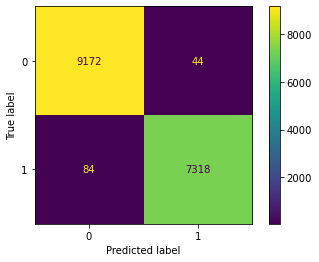

In [6]:
plot_confusion_matrix(model, X_test, y_test);

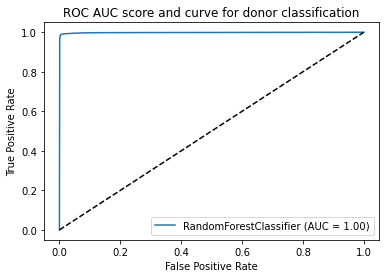

In [7]:
plot_roc_curve(model, X_test, y_test)
plt.title('ROC AUC score and curve for donor classification');
plt.plot([0,1], [0,1], 'k--')
plt.show();

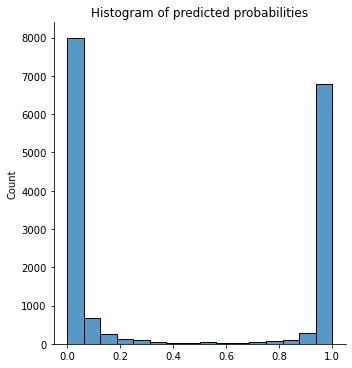

In [12]:
#plotting probabilities
y_pred_prob = model.predict_proba(X_test)
sns.displot(y_pred_prob[:, 1]);
plt.title('Histogram of predicted probabilities');

# Feature Importances

In [8]:
feature_import_df = pd.DataFrame(model.feature_importances_, 
                                   index =X_train.columns,  
                                   columns=['importance']).sort_values('importance', 
                                                                       ascending=False)

In [9]:
feature_import_df[0:15]

,importance
isClassDDonor,0.143072
primaryPropertyValue,0.104378
isClassCDonor,0.093773
NetWorth,0.087703
maxClassDDonation,0.086493
maxClassCDonation,0.063855
isClassBDonor,0.059912
sumClassDDonation,0.055948
maxClassBDonation,0.051538
totalHouseholdDebt,0.049557


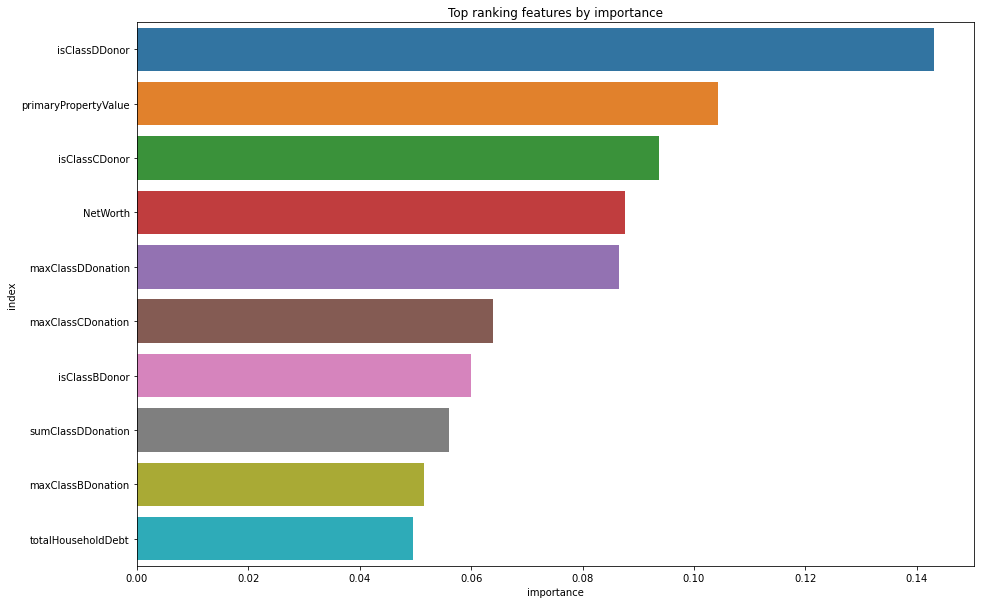

In [10]:
graph_feat_importance = feature_import_df.reset_index(col_fill = 'feature')

plt.figure(figsize=(15, 10))
x = graph_feat_importance['importance'].head(10)
y = graph_feat_importance['index'].head(10)
sns.barplot(x = x, y = y).set_title('Top ranking features by importance');

# Propensity Scoring